###  This Notebook is to read the CMIP6 GFDL-ESM4_ssp245_friver_monthly data for historical, 1990-2014, and future projection, 2015-2100

**1. save data within the LO_domain**
**2. for LO_grids, extract the maximal friver values each year and the corresponding month each year**
**3. save the data into .nc in order to do analysis in another notebook**


In [1]:
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from lo_tools import Lfun
from lo_tools import plotting_functions as pfun
Ldir = Lfun.Lstart()

In [2]:
# output location
source = 'GFDL_ESM4'
out_dir = Ldir['LOo'] / 'pre' / 'river'/ source
Lfun.make_dir(out_dir)

# figure location
fig_dir = Ldir['LOo'] / 'plots' / 'river_forcing'
Lfun.make_dir(fig_dir)

In [3]:
# read one of the datafile downloaded from GFDL_ESM4.0
ds = xr.open_dataset("/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/friver_Omon_GFDL-ESM4_ssp245_r1i1p1f1_gn_201501-203412.nc")
ds

<xarray.Dataset> Size: 415MB
Dimensions:    (time: 240, y: 576, x: 720, vertex: 4, bnds: 2)
Coordinates:
    lat        (y, x) float32 2MB ...
    lon        (y, x) float32 2MB ...
  * bnds       (bnds) float64 16B 1.0 2.0
  * time       (time) object 2kB 2015-01-16 12:00:00 ... 2034-12-16 12:00:00
  * x          (x) float64 6kB -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * y          (y) float64 5kB -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
Dimensions without coordinates: vertex
Data variables:
    friver     (time, y, x) float32 398MB ...
    lat_bnds   (y, x, vertex) float32 7MB ...
    lon_bnds   (y, x, vertex) float32 7MB ...
    time_bnds  (time, bnds) object 4kB ...
Attributes: (12/46)
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    external_variables:     areacello
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Omon
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    sub_experiment_id:      none
    tracking_id:            hdl:21.14100/4ab15c7a-8047-48fd-9c85-c3201eedce6e
    variable_id:            friver
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1

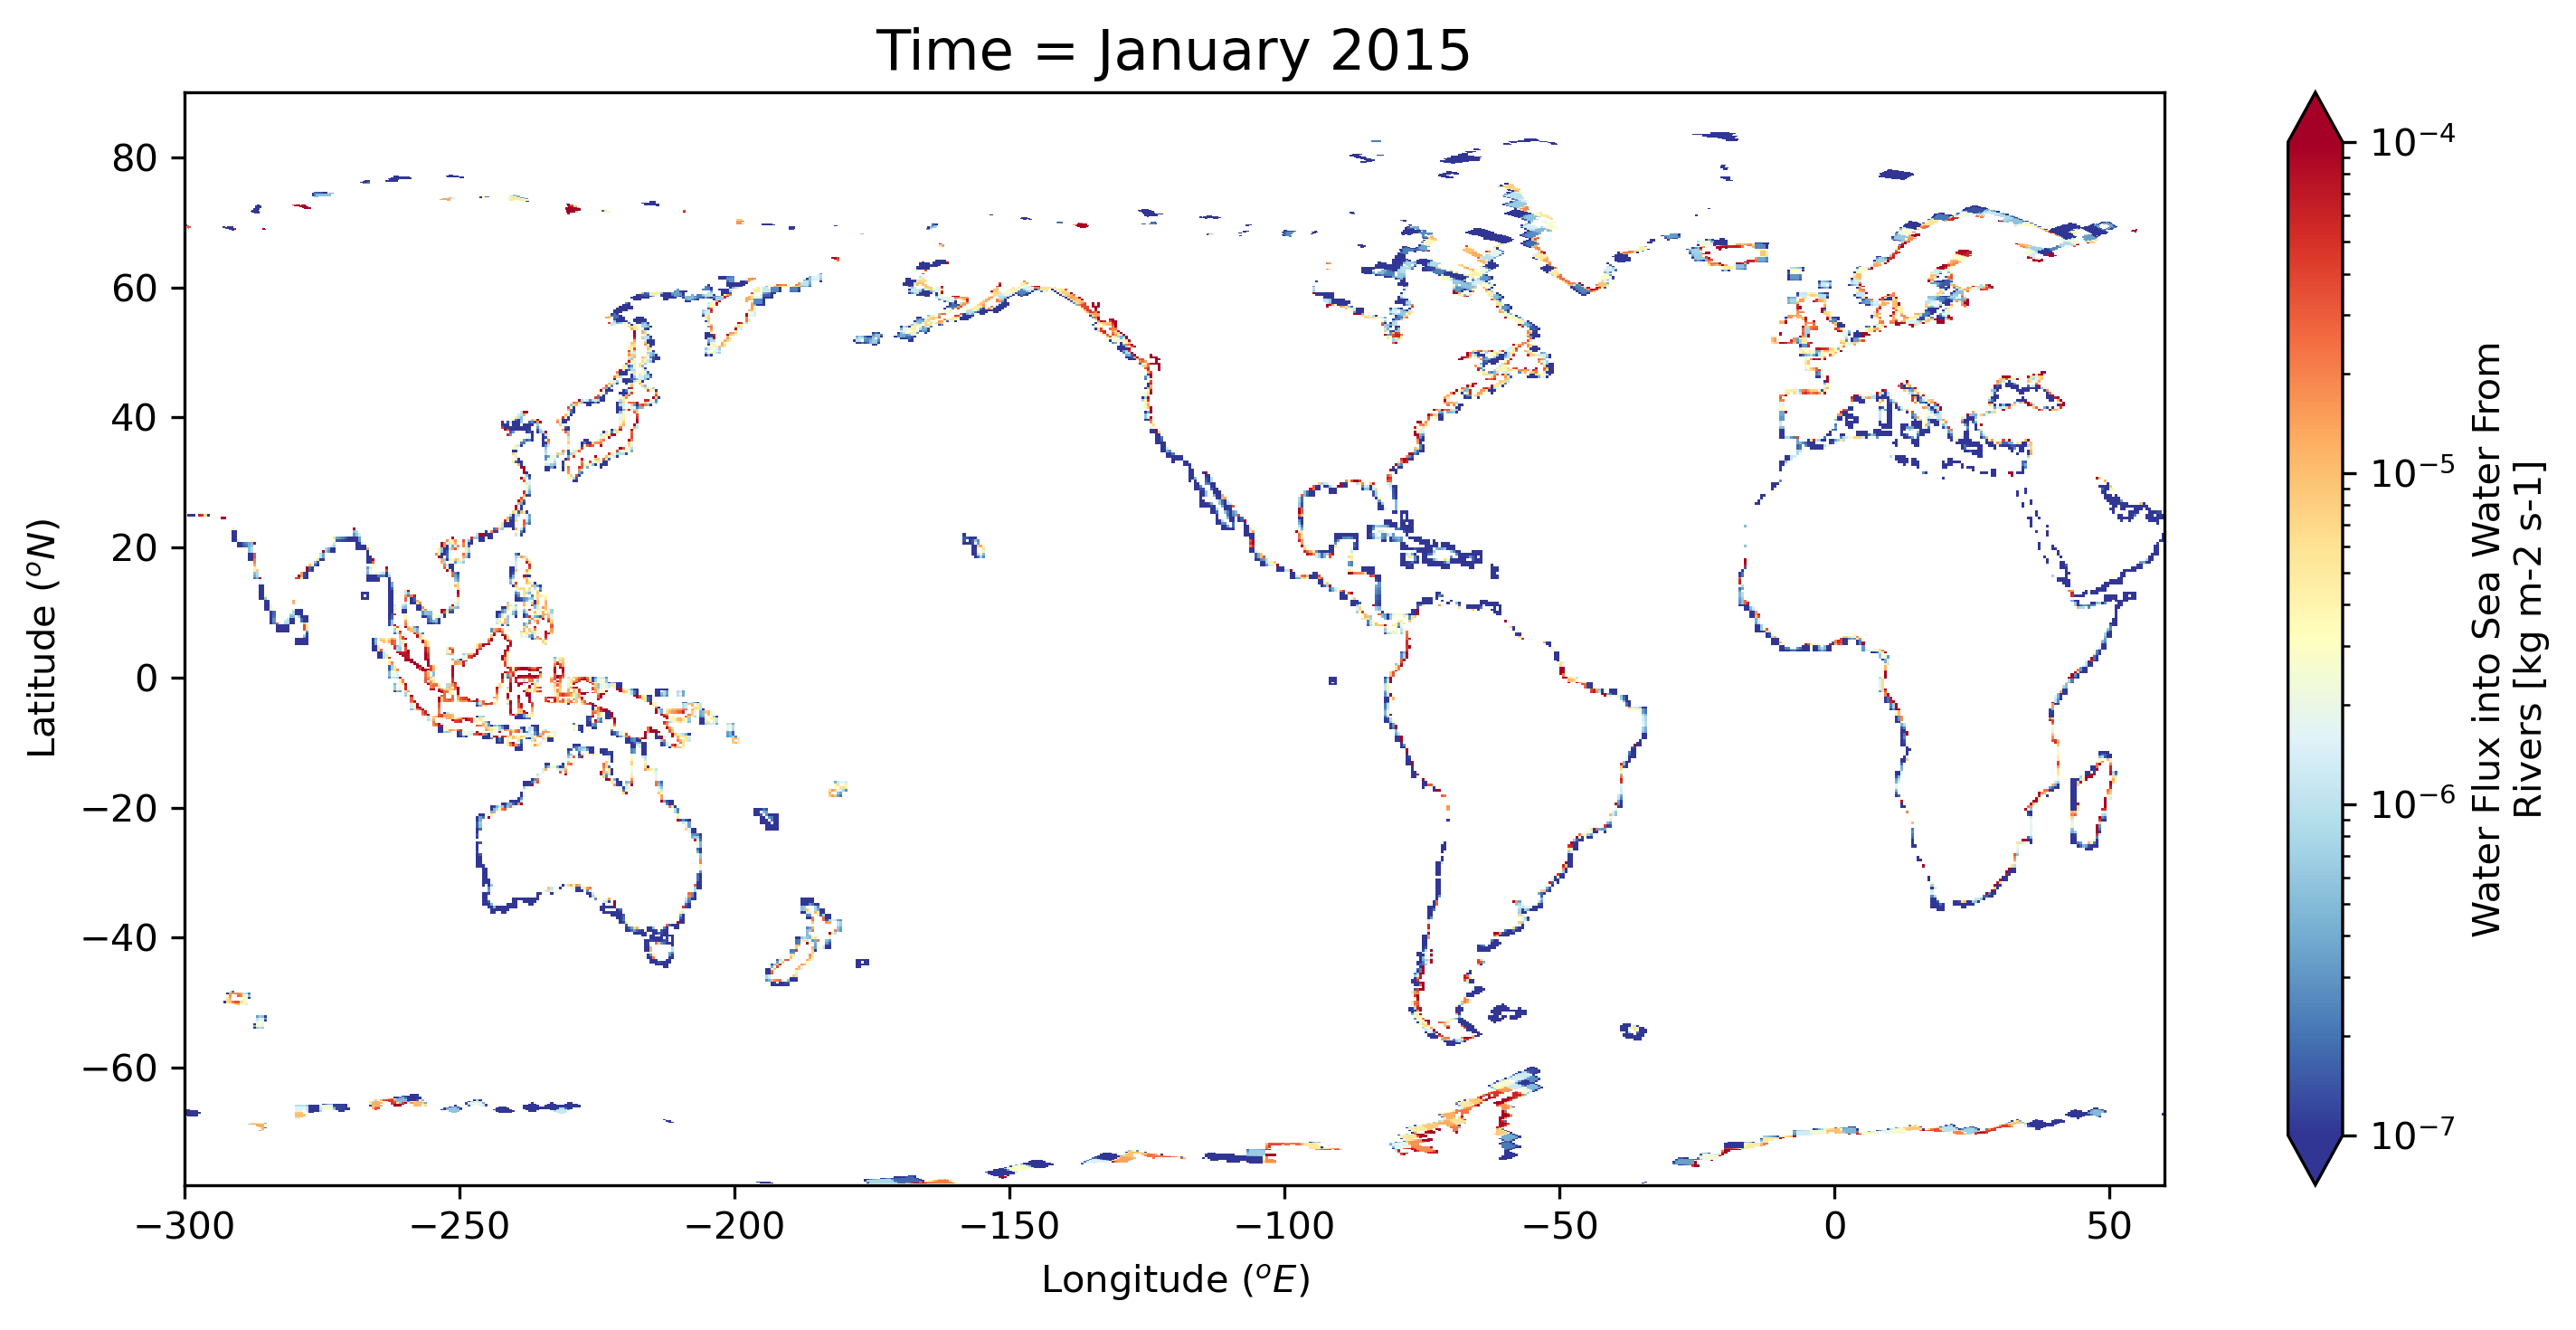

In [4]:
# slice data
start ='2015-01-16'
end = '2015-01-16'
river = ds['friver'].sel(time = slice(start, end))
date = pd.to_datetime(end).strftime('%B %Y')

# plot the global map on a selected day
fig = plt.figure(figsize=(10,5), dpi=300)
fig.set_facecolor('white')

# Set log scale for colorbar
norm = mcolors.LogNorm(vmin=1e-7, vmax=1e-4)  # Adjust vmin/vmax to fit data

plot = river.plot(x="lon", y="lat", cmap='RdYlBu_r', norm=norm)

plt.ion()
plt.xlabel('Longitude ($^{o}E$)')
plt.ylabel('Latitude ($^{o}N$)')

plt.title(f'Time = {date}',fontsize = 15)
plt.tight_layout()
fig.savefig(fig_dir/f'{source}_river_forcing_at_{start}.png', dpi=300)

plt.show()


In [5]:
# slice the data into LiveOcean domain
LO_river = ds['friver'].sel(time = slice(start, end),y=slice(42,52),x = slice(-130, -122))

In [6]:
# read the LiveOcean River data from USGS
Ldir = Lfun.Lstart(gridname='cas2k', tag='v0')
# get the list of rivers for this grid
gri_fn = Ldir['grid'] / 'river_info.csv'
gri_df = pd.read_csv(gri_fn, index_col='rname')
# read the climatology of river flow
ri_dir = Ldir['LOo'] / 'pre' / 'river' / Ldir['gtag']
CLM_df = pd.read_pickle(ri_dir / 'Data_historical' / ('CLIM_flow'  + '.p'))

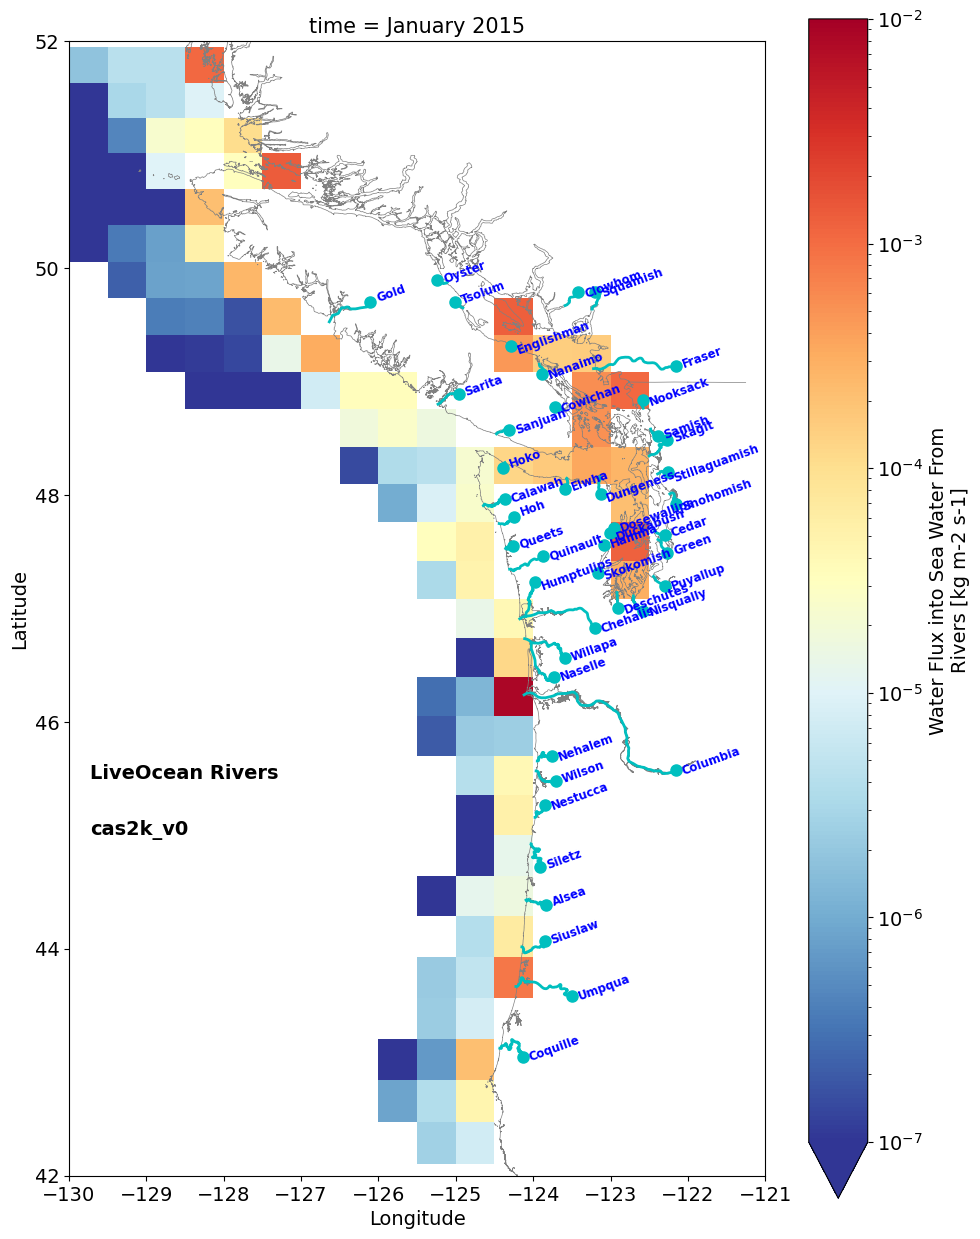

In [7]:
# PLOTTING

plt.close('all')
fs = 14
pfun.start_plot(fs=fs, figsize=(10,13))
fig = plt.figure()


ax = fig.add_subplot(111)
# Set log scale for colorbar
norm = mcolors.LogNorm(vmin=1e-7, vmax=1e-2)  # Adjust vmin/vmax to fit data
LO_river.plot(x="lon", y="lat", cmap='RdYlBu_r', norm=norm)
pfun.add_coast(ax, color='gray')
pfun.dar(ax)

for rn in gri_df.index:
    try:
        track_df = pd.read_pickle(ri_dir / 'tracks' / (rn + '.p'))
        x = track_df['lon'].to_numpy()
        y = track_df['lat'].to_numpy()
        ax.plot(x, y, '-c', linewidth=2)  # plot the USGS 45 rivers historical location 
        ax.plot(x[-1], y[-1], 'oc', markersize=8)

        if rn in CLM_df.columns:
            # rcol = 'r'
            rcol = 'b'
        else: rcol = 'b'

        if rn == 'dosewallips':
            dy = .11
        else:
            dy = .07

        ax.text(x[-1]+.06, y[-1]+dy, rn.title(), color=rcol, weight='bold',
                va='center',
                size=.6*fs, rotation=20)
    except FileNotFoundError:
        print('no track for ' + rn)
        pass

ax.text(.03,.35,'LiveOcean Rivers', weight='bold', transform=ax.transAxes)
ax.text(.03,.3, Ldir['gtag'], weight='bold', transform=ax.transAxes)
plt.title(f'time = {date}',fontsize = 15)
fig.tight_layout()

ax.set_xlim(-130, -121)
ax.set_ylim(42, 52)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.savefig(fig_dir/f'{source}_LO_45_river_forcing_at_{start}.png', dpi = 300)
plt.show()
pfun.end_plot()

### Read all the river data files from GFDL ESM4.0

In [8]:
# load all the files
file_list = sorted(glob.glob('/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/' + '*.nc'))
file_list

['/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/friver_Omon_GFDL-ESM4_historical_r1i1p1f1_gn_199001-200912.nc',
 '/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/friver_Omon_GFDL-ESM4_historical_r1i1p1f1_gn_201001-201412.nc',
 '/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/friver_Omon_GFDL-ESM4_ssp245_r1i1p1f1_gn_201501-203412.nc',
 '/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/friver_Omon_GFDL-ESM4_ssp245_r1i1p1f1_gn_203501-205412.nc',
 '/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/friver_Omon_GFDL-ESM4_ssp245_r1i1p1f1_gn_205501-207412.nc',
 '/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/friver_Omon_GFDL-ESM4_ssp245_r1i1p1f1_gn_207501-209412.nc',
 '/a1/fsoares/LiveOcean/future_projections/ESM4/ocean/friver/friver_Omon_GFDL-ESM4_ssp245_r1i1p1f1_gn_209501-210012.nc']

In [9]:
# read all the files
dt = xr.open_mfdataset(file_list)
# dt = xr.open_mfdataset(file_list[0:2])
dt = dt.convert_calendar("gregorian", align_on="year")


**1. save data within the LO_domain**

In [10]:
# zoom into LiveOcean domain
LO_river = dt['friver'].sel(y=slice(42,52),x = slice(-130, -122))
LO_river = LO_river.sel(time=slice('1993-01-01', None))
LO_river.to_netcdf(f"{out_dir}/GFDL-ESM4_ssp245_LO_domain_friver_monthly.nc")

In [11]:
"""
for any cell that is not NaN, plot the monthly time series
"""
# Loop through each grid point
time = LO_river['time'].values # Extract time variable

ii =0
for i in range(LO_river.sizes['y']):
    for j in range(LO_river.sizes['x']):
        values = LO_river.isel(y=i, x=j).values  # Extract time series at (y, x)        
        if not np.all(np.isnan(values)) and not np.all(values == 0.0):
            ii += 1
            # Split the time and values based on whether time is before or after 2015
            hist = time < np.datetime64('2023-01-01')
            fut = time >= np.datetime64('2023-01-01')

            # Create a plot
            plt.figure(figsize=(15, 4), dpi=300)

            # Plot before 2015 in one color
            plt.plot(time[hist], values[hist], marker='o', linestyle='-', color='black', label='Historical (1993-2022)')

            # Plot after 2015 in another color
            plt.plot(time[fut], values[fut], marker='o', linestyle='-', color='red', label='SSP2-4.5 (2023-2100)')

            # Add labels and title
            plt.xlabel('Time')
            plt.ylabel('River Flow (friver)')
            plt.title(f'Time Series at Grid (y={LO_river.y[i].values}, x={LO_river.x[j].values})')
            plt.grid()

            # Add a legend
            plt.legend()
            # Save the plot as a PNG file
            plot_filename = f"{fig_dir}/LO_domain_river_flow_hist_SSP2-4.5_y{i}_x{j}.png"
            plt.savefig(plot_filename)
            plt.show()

print('Total grid numbers are:', ii)

KeyboardInterrupt: 

**2. for LO_grids, extract the maximal friver values each year and the corresponding month each year**
**3. save the data into .nc in order to do analysis in another notebook**

In [12]:
time = LO_river['time'].values  # Extract time variable
yr_list = np.arange(pd.to_datetime(time).year[0], pd.to_datetime(time).year[-1] + 1)

In [ ]:
# Loop through each grid point
ii = 0
x_list, y_list = [], []
flow_mean_list, flow_max_list, month_flow_max_list = [], [], []
i_list, j_list = [], []
# delta_month = []
for i in range(LO_river.sizes['y']):
    for j in range(LO_river.sizes['x']):
        df = LO_river.isel(y=i, x=j)
        flow = df.values  # Extract time series at (y, x) 
        """
        for any cell that is not NaN, plot time series
        """
        if not np.all(np.isnan(flow)) and not np.all(flow == 0.0):
            ii += 1
            i_list.append(i)
            j_list.append(j)
            x_list.append(df.x.values)
            y_list.append(df.y.values)
            month_flow_max = []
            flow_max = []
            flow_mean = []
            for yr in yr_list:  # extract the maximal flow each year
                yr_data = df.sel(time=df.time.dt.year == yr)

                if np.all(np.isnan(yr_data.values)):
                    yr_mean, yr_max, month_max = np.nan, np.nan, np.nan
                else:
                    yr_max = np.nanmax(yr_data.values)
                    idx = np.nanargmax(yr_data.values)
                    month_max = yr_data.time[idx].dt.month.values
                    yr_mean = np.nanmean(yr_data.values)
                # print(yr,month_max)
                flow_max.append(yr_max)
                month_flow_max.append(month_max)
                flow_mean.append(yr_mean)

            flow_max_list.append(flow_max)
            month_flow_max_list.append(month_flow_max)
            flow_mean_list.append(flow_mean)

            # Split the time and values based on whether time is before or after 2015
            HIST = yr_list <  2023
            FUT = yr_list >= 2023
            # delta = np.mean(np.array(month_flow_max)[FUT]) - np.array(month_flow_max)[HIST]
            # delta_month.append(delta)
            # Create a plot
            plt.figure(figsize=(15, 10), dpi=300)
            plt.subplot(2,1,1)
            # Plot before 2015 in one color
            plt.plot(yr_list[HIST], np.array(flow_max)[HIST], marker='o', linestyle='-', color='black', label='Historical (1993-2022)')
            # Plot after 2015 in another color
            plt.plot(yr_list[FUT], np.array(flow_max)[FUT], marker='o', linestyle='-', color='red', label='SSP2-4.5 (2023-2100)')
            # Add labels and title
            plt.xlabel('Time')
            plt.ylabel('Max River Flux at a given year')
            plt.title(f'Time series of the maximal flux (friver) at Grid (y={LO_river.y[i].values:.2f}, x={LO_river.x[j].values:.2f})')
            plt.grid()
            # Add a legend
            plt.legend()
            plt.subplot(2,1,2)
            # Plot before 2015 in one color
            plt.plot(yr_list[HIST], np.array(month_flow_max)[HIST], marker='o', linestyle='-', color='black', label='Historical (1993-2022')
            # Plot after 2015 in another color
            plt.plot(yr_list[FUT], np.array(month_flow_max)[FUT], marker='o', linestyle='-', color='red', label='SSP2-4.5 (2023-2100)')
            # Add labels and title
            plt.xlabel('Time')
            plt.ylabel('Month with Max River Flux')
            plt.title(f'Time series of the months with max flux at Grid (y={LO_river.y[i].values:.2f}, x={LO_river.x[j].values:.2f})')
            plt.grid()
            # Add a legend
            plt.legend()
            # Save the plot as a PNG file
            plot_filename = f"{fig_dir}/LO_domain_river_flow_hist_SSP2-4.5_y{i}_x{j}_months_with_max_flow_{yr_list[0]}-{yr_list[-1]}.png"
            plt.savefig(plot_filename)
            plt.show()
print('Total grid numbers are:', ii)

# Convert lists to NumPy arrays
i_arr = np.array(i_list)
j_arr = np.array(j_list)

x_arr = np.array(x_list)
y_arr = np.array(y_list)

flow_max_arr = np.array(flow_max_list).T
flow_mean_arr = np.array(flow_mean_list).T
month_flow_max_arr = np.array(month_flow_max_list).T
# Create xarray Dataset with i, j as dimensions
flow_max_da = xr.DataArray(flow_max_arr, dims=['year', 'grid_index'], coords={'year': yr_list,
                                                                              'grid_index': np.arange(len(i_arr)),
                                                                              'i': ('grid_index', i_arr),
                                                                              'j': ('grid_index', j_arr),
                                                                              'x': ('grid_index', x_arr),
                                                                              'y': ('grid_index', y_arr),
                                                                              })
month_flow_max_da = xr.DataArray(month_flow_max_arr, dims=['year', 'grid_index'], coords={'year': yr_list,
                                                                                          'grid_index': np.arange(
                                                                                              len(i_arr)),
                                                                                          'i': ('grid_index', i_arr),
                                                                                          'j': ('grid_index', j_arr),
                                                                                          'x': ('grid_index', x_arr),
                                                                                          'y': ('grid_index', y_arr),

                                                                                          })

flow_mean_da = xr.DataArray(flow_mean_arr, dims=['year', 'grid_index'], coords={'year': yr_list,
                                                                                'grid_index': np.arange(len(i_arr)),
                                                                                'i': ('grid_index', i_arr),
                                                                                'j': ('grid_index', j_arr),
                                                                                'x': ('grid_index', x_arr),
                                                                                'y': ('grid_index', y_arr),
                                                                                })

# Create xarray Dataset
ds = xr.Dataset({
    'friver_max': flow_max_da,
    'friver_max_month': month_flow_max_da,
    'friver_mean': flow_mean_da,
})

filename = "GFDL-ESM4_ssp245_LO_domain_friver_mean_max_data.nc"
# Save to NetCDF
ds.to_netcdf(f"{out_dir}/{filename}")
print("NetCDF file saved: GFDL-ESM4_ssp245_LO_domain_friver_max_data.nc")
